# Geometrical Methods in Machine Learning
## Seminar 3: Intrinsic Dimension Estimation

In [32]:
from __future__ import print_function

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from math import pi
from sklearn.datasets import load_digits, fetch_olivetti_faces
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 1. Maximum Likelihood Estimation of Intrinsic Dimension

_Levina, E., & Bickel, P. J. (2005).  
Maximum Likelihood Estimation of Intrinsic Dimension.  
In Advances in Neural Information Processing Systems (pp. 777-784)._

The idea of the nearest-neighbor intrinsic dimension estimation is based on fact of the  that the number of sample points in $\mathbf{X} = \mathbb{R}^n$ falling into a ball around $\mathbf{x}$ is proportional to the radius of of the ball $R$, the dimension of the ball $d$ and the density $f(x)$ for which the well-known estimator exists

$$f(x) = \frac{k/n}{R^d V(d)},$$

where $V(d) = \pi^{d/2} [\Gamma (d/2+1)]^{-1}$ is the volume of unit sphere in $\mathbb{R}^d$ and $\Gamma(d) = (d - 1)!$ is the Gamma function.

Then the intrinsic dimension $d$ of the sample can be regressed out or estimated by the maximum likelihood appoarch.

Consider a dataset $\mathbf{X} \in \mathbb{R}^n$ of intrinsic dimension $d$. Fix a sample point $\mathbf{x} \in \mathbf{X}$. Define $B(\mathbf{x}, t)$ as a ball centered at $\mathbf{x}$ with radius $t$, such that $0 \leq t \leq R$, where $R$ is arbitrary small radius. Consider a random process, which counts the number of observations within a distance $t$ to $\mathbf{x}$

$$N(\mathbf{x}, t) = \sum_n \mathbb{I} \{\| \mathbf{x}_i - \mathbf{x} \| \leq t \} = \#\{\mathbf{x}_i \in B(\mathbf{x}, t) \}.$$

Approximating this (binomial, w/ fixed $n$) random process by a Poisson process and suppressing the dependence on $\mathbf{x}$ for now, we can write the rate $\lambda(t)$ of the Poisson process $N(t)$ as 

$$\lambda(t) = f(\mathbf{x}) \cdot V(d) \cdot d \cdot t^{d-1}.$$

Let $\theta = \log f(x)$ then log-likelihood of the observed process is:

$$L(d, \theta) = \int_{0}^{R} \log \lambda(t) d N(\mathbf{x}, t) - \int_{0}^{R} \lambda(t) dt$$

which should be maximized over parameters $d$ and $\theta$.

Maximum likelihood estimator for dimension $d$ at point $\mathbf{x}$ is:

$$\hat{d}_R(\mathbf{x}) = \left[ \frac{1}{N(\mathbf{x}, R)} \sum_{j=1}^{N(\mathbf{x}, R)} \log \frac{R}{r_j(\mathbf{x})} \right]^{-1}$$

where $r_j = \| \mathbf{x}_j - \mathbf{x} \|, j = 1, 2, \dots$ is the distance to the $j$-th nearest neighbor.

In practice, it may be more convenient to grow the number of neighbors $k$ rather than the radius of the sphere $R$. Let we use $k$ nearest neighbors $\mathbf{x}_1, \dots, \mathbf{x}_n$ of a point $\mathbf{x}$ and $R = \mathbf{x}_k$ then the MLE estimator is:

$$\hat{d}_k(\mathbf{x}) = \left[ \frac{1}{k - 1} \sum_{j=1}^{k - 1} \log \frac{r_k(\mathbf{x})}{r_j(\mathbf{x})} \right]^{-1}$$

Averaging over $\hat{d}_k(\mathbf{x})$ gives the intrinsic dimension of the dataset $\mathbf{X}$.

In [33]:
"""
Implementation of 'Maximum Likelihood Estimation of Intrinsic Dimension' by Elizaveta Levina and Peter J. Bickel
 
how to use
----------
 
The goal is to estimate intrinsic dimensionality of data, the estimation of dimensionality is scale dependent
(depending on how much you zoom into the data distribution you can find different dimesionality), so they
propose to average it over different scales, the interval of the scales [k1, k2] are the only parameters of the algorithm.
 
This code also provides a way to repeat the estimation with bootstrapping to estimate uncertainty.
 
Here is one example with swiss roll :
 
from sklearn.datasets import make_swiss_roll
X, _ = make_swiss_roll(1000)
 
k1 = 10 # start of interval(included)
k2 = 20 # end of interval(included)
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X, 
                             mode='bootstrap', 
                             nb_iter=500, # nb_iter for bootstrapping
                             verbose=1, 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)
# the shape of intdim_k_repeated is (nb_iter, size_of_interval) where 
# nb_iter is number of bootstrap iterations (here 500) and size_of_interval
# is (k2 - k1 + 1).
 
# Plotting the histogram of intrinsic dimensionality estimations repeated over
# nb_iter experiments
plt.hist(intdim_k_repeated.mean(axis=1))
 
"""
# from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
 
def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X)
    dist = dist[:, 1:]
    dist = dist[:, 0:k]
    assert dist.shape == (X.shape[0], k)
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1])
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1):
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

### 1.1 Artificial data

(Noisy) helix curve is given by parametric equation:

$$H(t) = \big( \sin(2 \pi t), \cos(2\pi t), t\big) + \varepsilon \\
\varepsilon \sim \mathcal{N}(0, \sigma)
$$

In [8]:
def helix(t, var=0.02):
    # your code here
    x = np.sin(2 * pi * t)
    y = np.cos(2 * pi * t)
    z = t
    return np.stack((x, y, z)) + np.random.normal(0, var, (3, t.shape[0]))

In [13]:
n = 500 # n samples
linspace = np.linspace(-1, 1, n)

data_helix = helix(linspace, 0.1)
data_helix.shape

(3, 500)

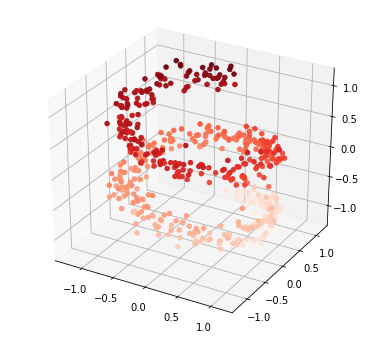

In [14]:
fig = plt.figure(figsize=(6.5,6))
ax = fig.gca(projection='3d')
ax.scatter(data_helix[0], data_helix[1], data_helix[2], alpha=0.95, c=((data_helix[2]+1)*255), cmap="Reds")
plt.show()

#### Exercise

Estimate sample dimensionality using repeated function and given parameters. Plot histogram, print mean values and std. It could be comfortable to make histogram in a new cell. Useful functions: repeated, matplotlib.pyplot.hist=plt.hist 

In [15]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 10

sample = data_helix

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_helix.T, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

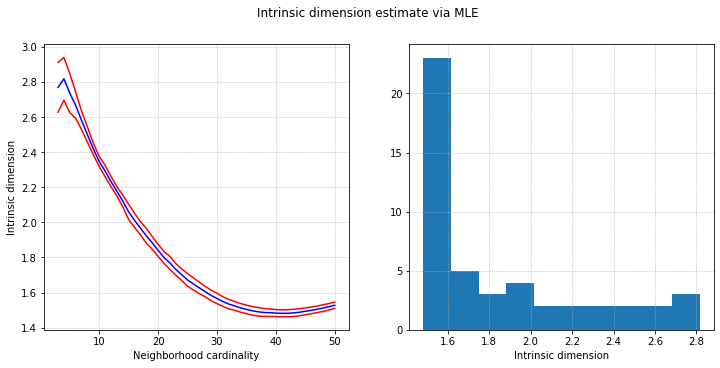

In [16]:
fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()

### 1.2. Airfoils

#### Exercise

Estimate intrinsic dimension of airfoils sample and compare results with PCA ones.

In [17]:
data_airfoils = np.loadtxt('../seminar1/data/airfoils.csv', delimiter=',')
data_airfoils.shape

(199, 59)

In [18]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 20

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_airfoils, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

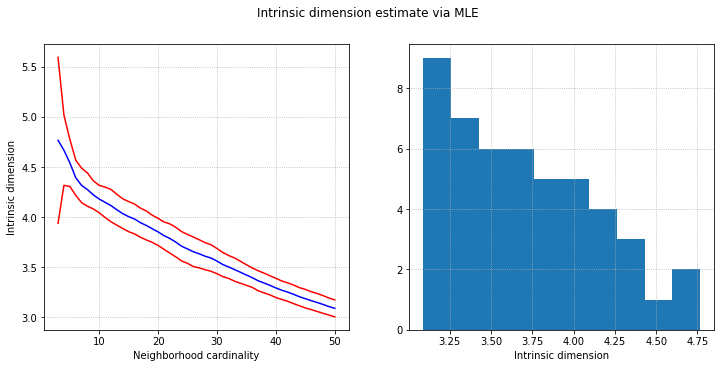

In [19]:
fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()

### 1.3 MNIST

#### Exercise

Estimate intrinsic dimension of digits sample and compare results with PCA ones

In [20]:
data_mnist = load_digits().data
data_mnist.shape

(1797, 64)

In [21]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 5

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_mnist, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

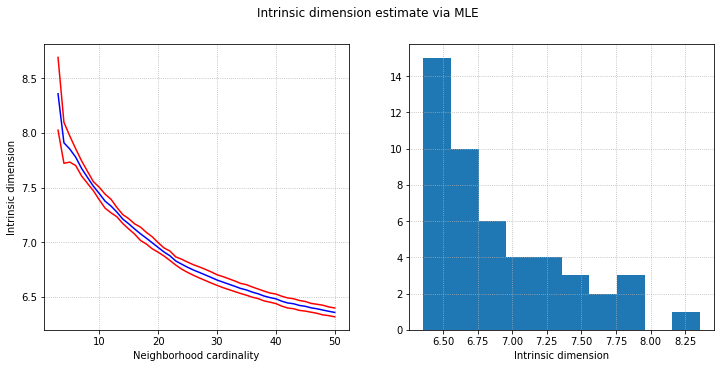

In [22]:
fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()

### 1.4 Olivetti faces

#### Exercise

Estimate intrinsic dimension of faces sample and compare results with PCA ones.

In [23]:
data_faces = fetch_olivetti_faces(shuffle=True).data
data_faces.shape

(400, 4096)

In [24]:
k1 = 3 # start of interval(included)
k2 = 50 # end of interval(included)
nb_iter = 5

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data_faces, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

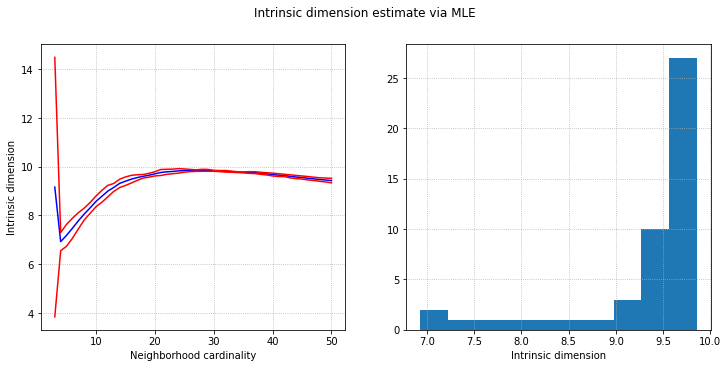

In [25]:
fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()

## 2. Local PCA

Let $\{x_1, x_2, \dots, x_n \} \subset \mathbb{R}^D$ be a data sample and $U(x_i)$ - a neighborhood of each point, excluding $x_i$ itself, with cardinality $k$. By applying PCA locally, i.e. computing eigenvalues $\lambda_{i,1} \geq \lambda_{i,2} \geq \dots \lambda_{i,D}$ of each neighborhood covariance matrix: $\mathbf{S}_i = \frac{1}{k-1}(\mathbf{U}(x_i) - x_i) (\mathbf{U}(x_i) - x_i)^T$ and then averaging over eigenvalues $\lambda_j = n^{-1} \sum_{i=1}^n \lambda_{i,j}$, where $j = 1, 2, \dots, D$ one can estimate intrinsic dimension $d$ by thresholding variance explained with averaged eigenvalues.

#### Exercise

1. Implement Local PCA method for intrinsic dimensionality estimation (lecture slides, pp. 25-29).  
2. Apply the method to artificial and real data, compare results with global PCA and MLE methods for different number of nearest neighbors $k$, conclude.

For neighborhood selection you may use `kneigbbors` method from scikit-learn's `NearestNeighbors`.

In [36]:
# k of nearest neighbors to select
k = 15

X = data_mnist

# select neighborhood for each point
nn = NearestNeighbors(n_neighbors=k).fit(X)
idx = nn.kneighbors(return_distance=False)
U = X[idx]

eigenvalues = np.empty((0, X.shape[1]), np.float)

for i in range(X.shape[0]):
    
    # center the data in neighborhood by subtracting x_i
    data_centered = U[i] - X[i]
    
    # estimate covariance matrix
    covariance = np.dot(data_centered.T, data_centered) / (k - 1)
    
    # SVD decomposition
    _, eigenvalues_i, _ = np.linalg.svd(covariance)
    
    # add local eigenvalues to array of eigenvalues
    eigenvalues = np.vstack((eigenvalues, eigenvalues_i))

In [37]:
# average over eigenvalues for all neighborhoods
eigenvalues_mean = np.mean(eigenvalues, axis=0)
eigenvalues_mean

array([2.43529853e+02, 8.66444982e+01, 5.61774294e+01, 3.92672366e+01,
       2.82312173e+01, 2.08546358e+01, 1.55177111e+01, 1.16813752e+01,
       8.85803603e+00, 6.78311581e+00, 5.13871486e+00, 3.90915907e+00,
       2.86693880e+00, 2.04129777e+00, 1.29956004e+00, 2.07295415e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
       2.06163853e-14, 2.06163853e-14, 2.06163853e-14, 2.06163853e-14,
      

#### Exercise

Compute explained and cumulative explained variance. Use results to estimate intrinsic dimension of data samples.

$$EV_i := \frac{\lambda_i}{\lambda_1 + \dots + \lambda_D}$$
$$CEV_i := \frac{\sum_{i=1}^{d} \lambda_i}{\sum_{j=1}^{D} \lambda_j}$$

In [38]:
EV = eigenvalues_mean / eigenvalues_mean.sum()
CEV = np.cumsum(EV)

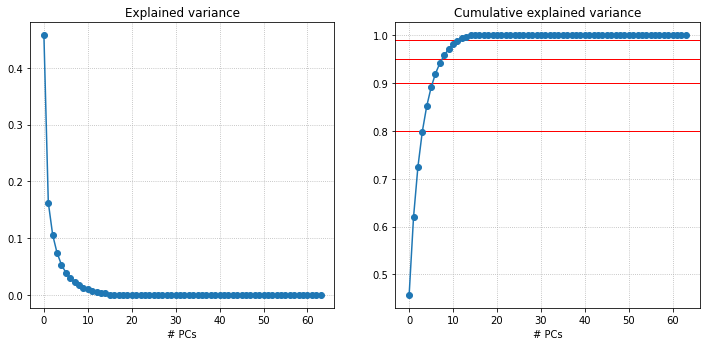

In [40]:
# plot EV/CEVs
fig = plt.figure(figsize=(12,5.25))

plt.subplot(121)
plt.title("Explained variance")
plt.xlabel("# PCs")
plt.grid(linestyle="dotted")
plt.plot(EV, "o-")

plt.subplot(122)
plt.title("Cumulative explained variance")
plt.axhline(linewidth=1, y=0.99, color='r')
plt.axhline(linewidth=1, y=0.95, color='r')
plt.axhline(linewidth=1, y=0.9, color='r')
plt.axhline(linewidth=1, y=0.8, color='r')
plt.xlabel("# PCs")
plt.grid(linestyle="dotted")
plt.plot(CEV, "o-")

#### Exercise

Apply local PCA method to estimate intrinsic dimensions of the datasets previously considered in this seminar

In [3]:
# your code here

### 3. Intrinsic dimension of decision rule

#### Exercise

Estimate intrinsic dimension of decision rule separating two classes of digits dataset estimated via SVM support vectors. Compare the intrinsic dimension of decision rule to that of data, conclude.

In [71]:
idx1, idx2 = 0, 1

In [72]:
X_mnist, y_mnist = load_digits(return_X_y=True)
X = np.concatenate([X_mnist[y_mnist==idx1], X_mnist[y_mnist==idx2]])
y = np.concatenate([np.zeros_like(y_mnist[y_mnist==idx1]), np.ones_like(y_mnist[y_mnist==idx2])])
X.shape, y.shape

((360, 64), (360,))

In [73]:
svm = SVC(C=0.2).fit(X, y)
X_decision = svm.support_vectors_
X_decision.shape

(65, 64)

#### Intrinsic dimension of data

In [74]:
k1 = 3 # start of interval(included)
k2 = 10 # end of interval(included)
nb_iter = 10

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

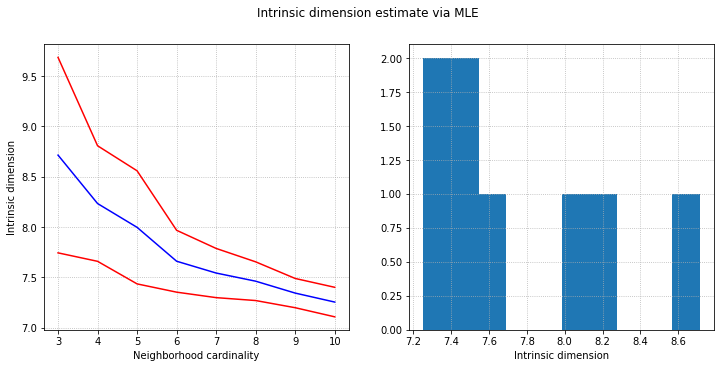

In [75]:
fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()

#### Intrinsic dimension of decision rule

In [76]:
k1 = 3 # start of interval(included)
k2 = 10 # end of interval(included)
nb_iter = 10

intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X_decision, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

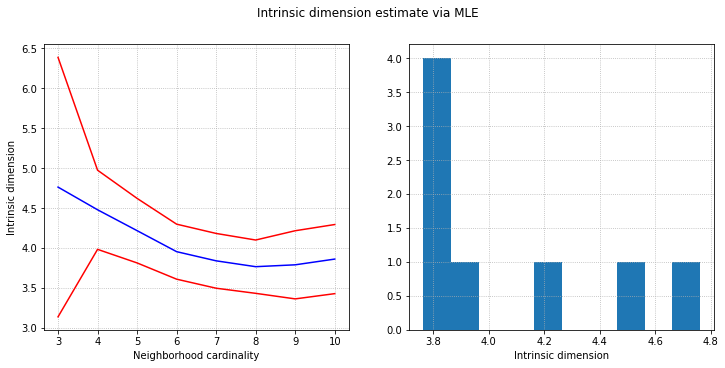

In [77]:
fig = plt.figure(figsize=(12,5.25))

plt.suptitle("Intrinsic dimension estimate via MLE")

plt.subplot(121)
plt.xlabel("Neighborhood cardinality")
plt.ylabel("Intrinsic dimension")
plt.grid(linestyle='dotted')

plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0), 'b')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
plt.plot(range(k1, k2 + 1), np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

plt.subplot(122)
plt.xlabel("Intrinsic dimension")
plt.grid(linestyle="dotted")

plt.hist(intdim_k_repeated.mean(axis=0))
plt.show()